### Bib Detector 
##### Informatics 4000 Mini-Project #3

An application that leverages deep learning models for vision-based race number detection and gender classification.

*****************************************************************************************************************************

**Datasets used in this application:**

- **'bib-numbers'**- I combined two datasets: [OCR Racing Bib Number Recognition](https://www.kaggle.com/datasets/trainingdatapro/ocr-race-numbers/) and [RBNR](https://people.csail.mit.edu/talidekel/RBNR.html).
- **'gender'** - I used a [dataset downloaded from Kraggle](https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset). 

In [47]:
import os
import torch 

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [49]:
# FILE COUNT FOR 'bib-numbers'

# Parent directory containing the 'bib-numbers' subdirectory
parent_directory = 'datasets'

# List of subdirectories
subdirectories = ['train', 'test']

# Iterate through the subdirectories to count the files
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(parent_directory, 'bib-numbers', subdirectory)
    file_count = sum([len(files) for _, _, files in os.walk(subdirectory_path)])
    print(f"Number of files in '{subdirectory}' directory: {file_count}")

# Calculate the total number of files
total_train_files = sum([len(files) for _, _, files in os.walk(os.path.join(parent_directory, 'bib-numbers', 'train'))])
total_test_files = sum([len(files) for _, _, files in os.walk(os.path.join(parent_directory, 'bib-numbers', 'test'))])

Number of files in 'train' directory: 121
Number of files in 'test' directory: 52


In [50]:
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image


image 1/1 /Users/maddiehope/Desktop/bib-detector/datasets/bib-numbers/test/01.JPG: 640x480 3 persons, 148.7ms
Speed: 6.2ms preprocess, 148.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


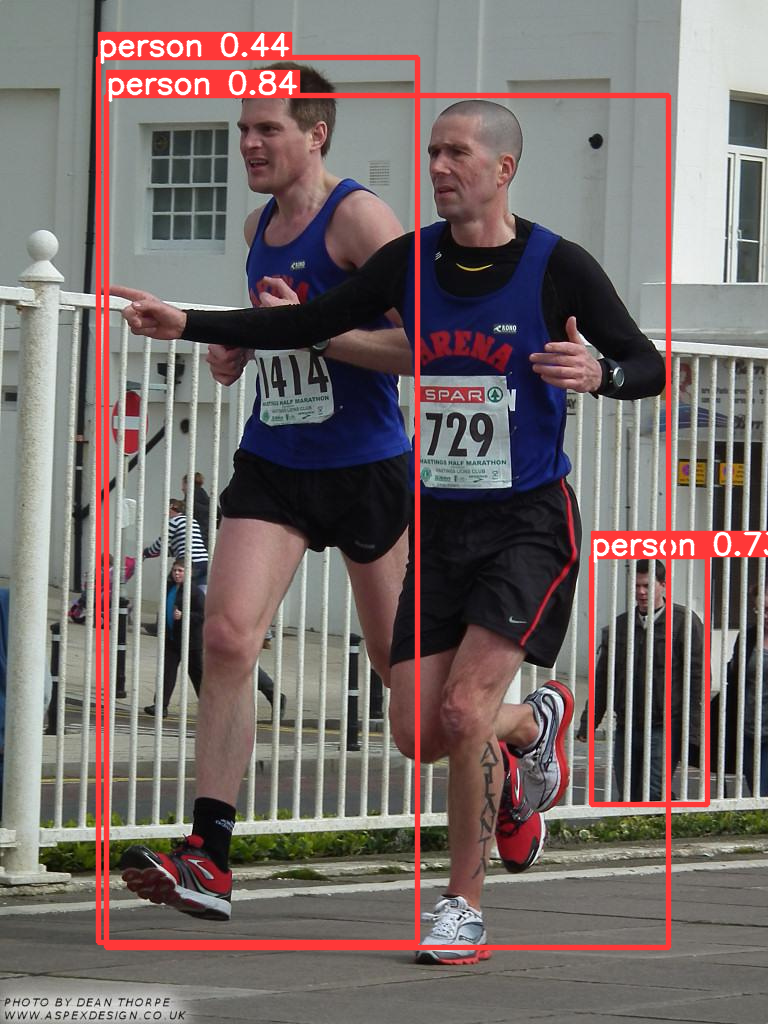

In [51]:
# * The following is modified from an example: *

# Load a pretrained YOLOv8n model
model_people = YOLO('yolov8n.pt') 

# Make the only detection class be 'person'
model_people.classes = ['person']

# Run inference on 'bus.jpg'
results = model_people('datasets/bib-numbers/test/01.JPG')  # results list

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    display(im) # show image in output 

As you can see in the image above, YOLOv8n can detect people. Now we have to figure out how to make it detect bibs & numbers within this bibs.

In order to do this, I will need to annotate my training data so that boundary boxes are drawn around the bibs shown in every image. This will help the model learn what exactly a bib is. 

For the next steps of this process, this [guide on Roboflow](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/) was beneficial to me. I also referenced the [Ultralytics website](https://docs.ultralytics.com) often.

The first step is to annotate my training images so that the 'bib' class of objects are clearly boxed in for the model to see and train on. I used the **Roboflow Annotator** to do this.

In [52]:
from roboflow import Roboflow

In [53]:
# Dataset Download Parameters

rf = Roboflow(api_key="yYpsVAGAUqStCCpiXk8k")

project = rf.workspace("university-of-georgia-k4dwo").project("bib-detection-sinjn")

dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Bib-Detection--1 in yolov5pytorch:: 100%|██████████| 355/355 [00:00<00:00, 1177.92it/s]


*****************************************************************************************************************************

**NOTE**: before you can run the code below, you have to go into **'Bib-Detection--1/data.yaml'** and **CHANGE** this line of code: 

##### **val: Bib-Detection--1/valid/images**

changes to:

##### **val:**

There is **NO validation data in this dataset**. I am not sure how to stop the valid section from downloading through Roboflow, so inbewteen running the cell above and the cell below you must manually make this change or you will get an error.

You will probably also have to edit the train and test paths in this file, as they will be different for your computer.

*****************************************************************************************************************************

For reference, here is the text in my 'data.yaml' looks like before the following cell is able to run properly:

In [54]:
'''

names:
- Bib
nc: 1
roboflow:
  license: MIT
  project: bib-detection-sinjn
  url: https://universe.roboflow.com/university-of-georgia-k4dwo/bib-detection-sinjn/dataset/1
  version: 1
  workspace: university-of-georgia-k4dwo
test: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test
train: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/train
val:

'''

'\n\nnames:\n- Bib\nnc: 1\nroboflow:\n  license: MIT\n  project: bib-detection-sinjn\n  url: https://universe.roboflow.com/university-of-georgia-k4dwo/bib-detection-sinjn/dataset/1\n  version: 1\n  workspace: university-of-georgia-k4dwo\ntest: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test\ntrain: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/train\nval:\n\n'

OR you can use this function to write-over the 'data.yaml' file, so you do not have to go in a manually change anything:

In [55]:
import yaml

data = {
    "names": ["Bib"],
    "nc": 1,
    "roboflow": {
        "license": "MIT",
        "project": "bib-detection-sinjn",
        "url": "https://universe.roboflow.com/university-of-georgia-k4dwo/bib-detection-sinjn/dataset/1",
        "version": 1,
        "workspace": "university-of-georgia-k4dwo"
    },
    "test": "/Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test",
    "train": "/Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/train",
    "val": None
}

# COMMENT CODE BELOW IF YOU DO NOT WISH TO USE THIS FUNCTION TO WRITE OVER DATA.YAML
with open('Bib-Detection--1/data.yaml', 'w') as file:
    yaml.dump(data, file)

Now I can begin the training process through YOLO using my custom dataset:

In [56]:
'''

The lines below are commented out becuase I only needed to train the model ONCE.

After it is initally trained and the weights are saved to my computer, 
I can just use the next cell to initalize the model everytime I re-run my cells.

If this is your first time running the cells in this notebook, I would uncomment the following lines and take note of the next markdown cell. 

'''

#model_bib = YOLO('yolov8n.pt')

#model_bib = model_bib.train(data= f"{dataset.location}/data.yaml" , epochs=100, imgsz=640, device='cpu')

'\n\nThe lines below are commented out becuase I only needed to train the model ONCE.\n\nAfter it is initally trained and the weights are saved to my computer, \nI can just use the next cell to initalize the model everytime I re-run my cells.\n\nIf this is your first time running the cells in this notebook, I would uncomment the following lines and take note of the next markdown cell. \n\n'

*****************************************************************************************************************************

**NOTE**: you will have to change the following file path to the model below to wherever the best weights saved on your computer. 

At the end of the cell ouput above, it gives me this statement:

#### **Validating /Users/maddiehope/runs/detect/train15/weights/best.pt...**

This was the file path I used below to create my model object.

*****************************************************************************************************************************

Now we can evaluate the performance metrics of this model:

In [57]:
model_bib = YOLO("/Users/maddiehope/runs/detect/train15/weights/best.pt") # you will need to change the file path here 

metrics = model_bib.val(data = f"{dataset.location}/data.yaml", split = "test")

print(f"\n")
print("Precision:", metrics.results_dict['metrics/precision(B)'])
print("Recall:", metrics.results_dict['metrics/recall(B)'])
print("mAP50:", metrics.results_dict['metrics/mAP50(B)'])
print("mAP50-95:", metrics.results_dict['metrics/mAP50-95(B)'])
print("Fitness:", metrics.results_dict['fitness'])

'''

NOTE: if you get an error while running this cell, look above and make sure you have made the neccessary changes to data.yaml.
      After you make those changes, re-run this cell (do not "Run all" because data.yml will be re-written again).

'''

Ultralytics YOLOv8.0.209 🚀 Python-3.9.18 torch-1.12.1 CPU (Intel Core(TM) i5-8257U 1.40GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]
                   all         52        124      0.934      0.903      0.951      0.547
Speed: 5.0ms preprocess, 172.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /Users/maddiehope/runs/detect/val26




Precision: 0.9336284543004645
Recall: 0.9032258064516129
mAP50: 0.9510731129426865
mAP50-95: 0.5465752902845515
Fitness: 0.5870250725503651


'\n\nNOTE: if you get an error while running this cell, look above and make sure you have made the neccessary changes to data.yaml.\n      After you make those changes, re-run this cell (do not "Run all" because data.yml will be re-written again).\n\n'

The metrics on the model look great. Precision, recall, and mAP50 are all very high. mAP50-95 is lower, but it still isn't terrible. The overall fittness is also mid, but with the high precision I'm not upset.


image 1/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/01_JPG.rf.e62f0206ee6fdfeb9519ad79791c38e6.jpg: 640x640 2 Bibs, 197.7ms
image 2/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/02_JPG.rf.6b6e8af4c2d675705e2901a4f955adc6.jpg: 640x640 1 Bib, 164.1ms
image 3/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/03_png.rf.8b75100491cd3982f280abb0ac5373d2.jpg: 640x640 4 Bibs, 141.7ms
image 4/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/04_png.rf.06743e8f75445862c2afa1da7e7fbd78.jpg: 640x640 4 Bibs, 155.7ms
image 5/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/05_JPG.rf.a0be7042ffafd212dbbf78d3675fbb58.jpg: 640x640 1 Bib, 139.7ms
image 6/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/06_JPG.rf.0f03e35464b9f7c2acea2054bb99b281.jpg: 640x640 1 Bib, 146.5ms
image 7/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/07_png.rf.faa67be

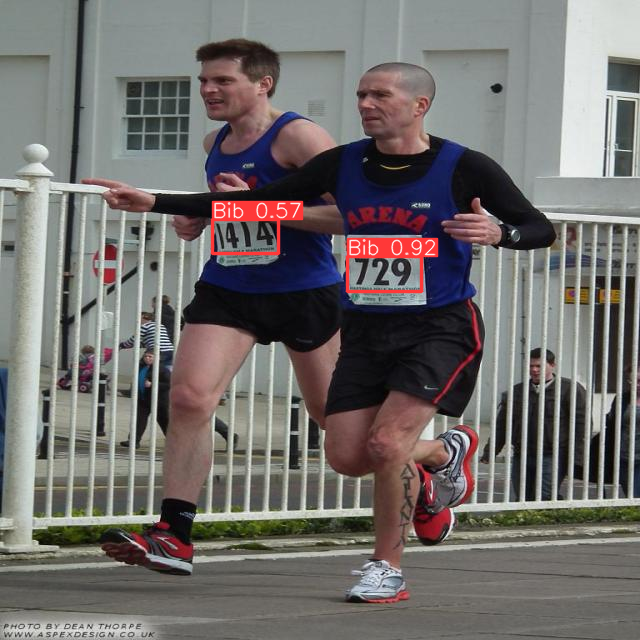

In [58]:
results = model_bib.predict(source=f"{dataset.location}/test/images", conf=0.25) # conf is object confidence threshold, setting to 25%

# Show the results
# I will only display the first image in the testing set b/c that is the image we initally tried using model_people

results_1 = results[0]

im_array = results_1.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im) # show image in output 

Yay!! The model is now trained to detect bibs and the predictions look great! The next step is to create a pipeline of the people model & the bib model so that when given an image, it can detect both.

In [59]:
image_path = 'datasets/bib-numbers/test/01.JPG' # same image used from model_people & model_bib prediction examples

In [60]:
import pandas as pd

In [61]:
def prediction_pipeline(image):

    '''

    Takes a string image path and runs it through a person detection model & then a bib detection model.

    '''

    people_list = []
    bibs_list = []

    '''

    The lists above are where the cropped images will be saved (matched by index).

    This is so that when we use the gender classifer on the person & the number detector on the bib, both results will be able to be paired 
    efficiently in the databases. 

    '''

    # Convert the input image path back to an actual image
    # (needed for person cropping and image detection in bib model)

    im = Image.open(image) # Open image using PIL

    # If the image has an alpha channel (transparency), convert it to RGB
    if im.mode == 'RGBA':
        im = im.convert('RGB')
    
    # Run the image through people model
    model_people_result = model_people(im)

    for i, people in enumerate(model_people_result):

        people_boxes = people.boxes.xyxy.tolist() # extracts the bounding box coordniates from the results attributes
                                                  # setting the torch tensor to list will result in a list of lists,
                                                  # where each list within the list is a row of the tensor
        
        for b in people_boxes: # for every row of the tensor, it is the coordinates of a detected person box

            x_min, y_min, x_max, y_max = map(int, b) # extracting these coordinates from the rows 

            person_roi = im.crop((x_min, y_min, x_max, y_max)) # crops the region of interest (ROI) containing the person from the original image

            r = model_bib(person_roi)  # runs the cropped ROI through the bib model

            bib_box = r[0].boxes.xyxy.tolist()              # takes the model results and gets the bounding box coordinates

            if (bib_box != []): # making sure there IS a bib for the person
                x_min, y_min, x_max, y_max = map(int, bib_box[0])  # extracting these coordinates from the rows
                                                                    # no loop is necessary for the bib cropping b/c there should only be 1 bib per person 'b'

                bib_roi = person_roi.crop((x_min, y_min, x_max, y_max)) # crops the new region of interest (ROI) from the exisiting crop of the person
                                                                    # new ROI crop should be of the bib

                # Adding the cropped image of the person (person_roi) and the cropped image of the bib (im)
                people_list.append(person_roi)
                bibs_list.append(bib_roi)

    return people_list, bibs_list


In [62]:
people_list, bibs_list = prediction_pipeline(image_path)


0: 640x480 3 persons, 146.8ms
Speed: 6.1ms preprocess, 146.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 2 Bibs, 136.0ms
Speed: 4.6ms preprocess, 136.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 (no detections), 85.1ms
Speed: 2.1ms preprocess, 85.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 1 Bib, 78.4ms
Speed: 5.0ms preprocess, 78.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


In [63]:
# Displaying the cropped images of the people and their bibs

def display_predictions(people_list, bibs_list):

    for index in range(len(people_list)): # the length of people_list and bibs_list should be the same

        print(f'PERSON DETECTED: ')
        display(people_list[index])
        print(f'\nBIB DETECTED:')
        display(bibs_list[index])

PERSON DETECTED: 


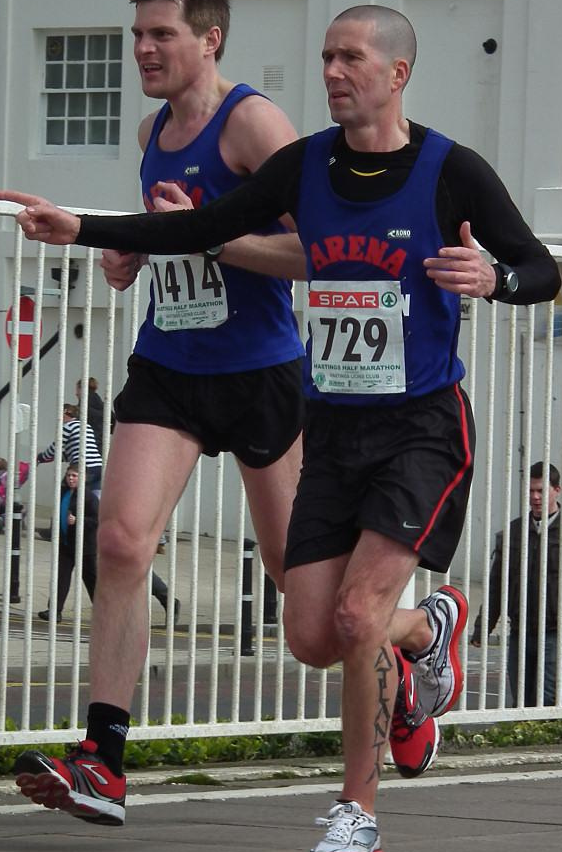


BIB DETECTED:


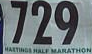

PERSON DETECTED: 


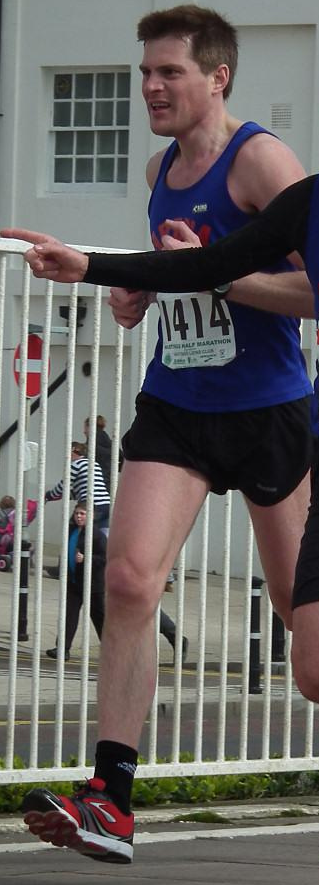


BIB DETECTED:


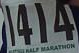

In [64]:
display_predictions(people_list, bibs_list)

In [65]:
# Trying the detection out on more of the test images

image_paths = [ 'datasets/bib-numbers/test/02.JPG',
                'datasets/bib-numbers/test/03.png',
                'datasets/bib-numbers/test/04.png',
                'datasets/bib-numbers/test/05.JPG' ]

In [66]:
def multiple_predicition_pipeline(image_paths):
    '''

    Takes multiple string image paths and runs them through the prediction_pipeline() function.

    '''

    total_people_list = []
    total_bib_list = []

    for image_path in image_paths:
        people_list, bibs_list = prediction_pipeline(image_path)
        total_people_list += people_list
        total_bib_list += bibs_list

    return total_people_list, total_bib_list

In [67]:
people_list, bibs_list = multiple_predicition_pipeline(image_paths)


0: 640x480 1 person, 147.4ms
Speed: 7.8ms preprocess, 147.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 1 Bib, 88.8ms
Speed: 6.0ms preprocess, 88.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 12 persons, 173.4ms
Speed: 7.1ms preprocess, 173.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x288 3 Bibs, 113.3ms
Speed: 3.9ms preprocess, 113.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 (no detections), 123.3ms
Speed: 4.9ms preprocess, 123.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 (no detections), 71.0ms
Speed: 4.0ms preprocess, 71.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 (no detections), 173.5ms
Speed: 10.6ms preprocess, 173.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 (no detections), 171.0ms
Speed: 5.1ms preprocess, 171.0ms inference, 0.6ms po

PERSON DETECTED: 


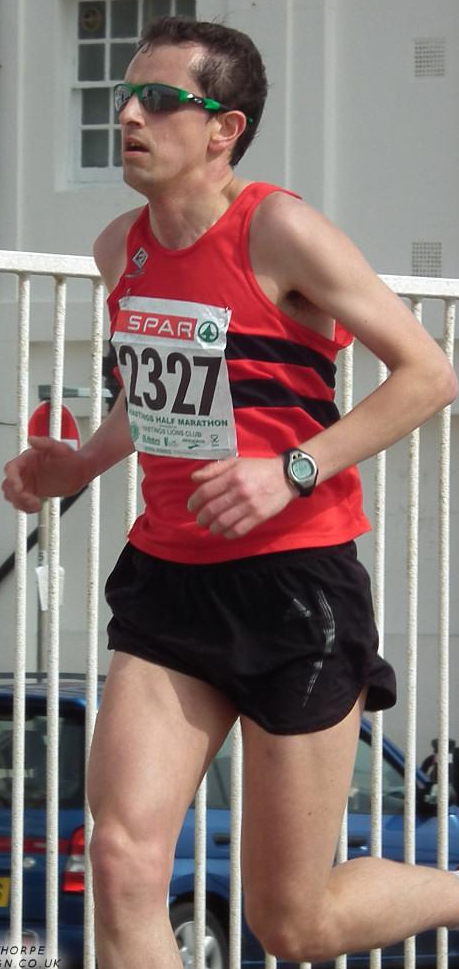


BIB DETECTED:


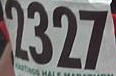

PERSON DETECTED: 


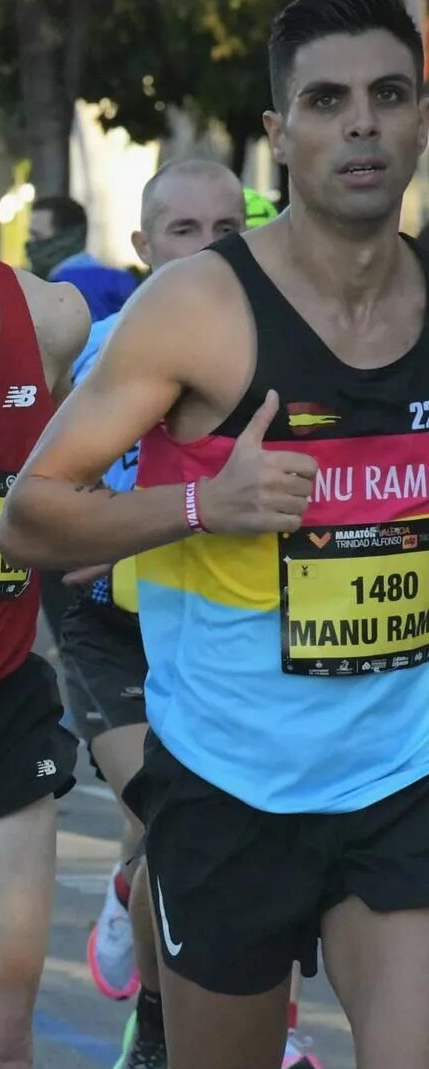


BIB DETECTED:


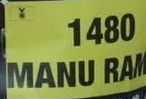

PERSON DETECTED: 


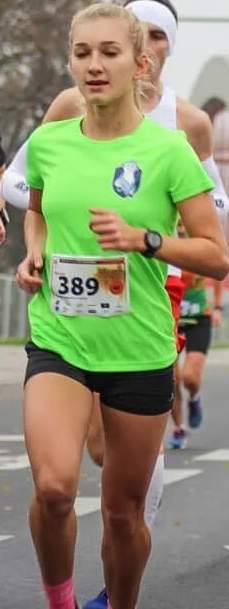


BIB DETECTED:


PERSON DETECTED: 


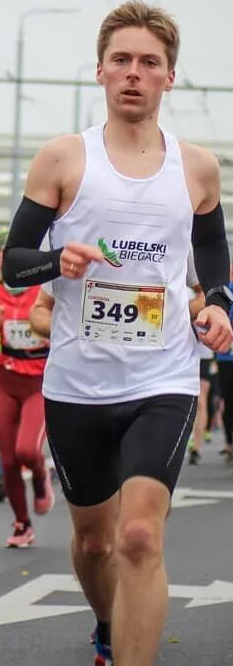


BIB DETECTED:


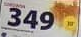

PERSON DETECTED: 


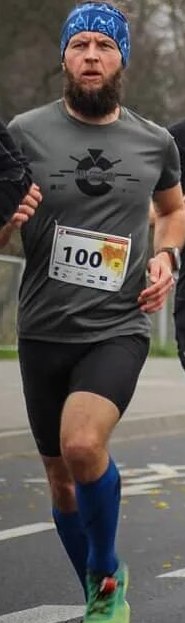


BIB DETECTED:


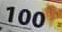

PERSON DETECTED: 


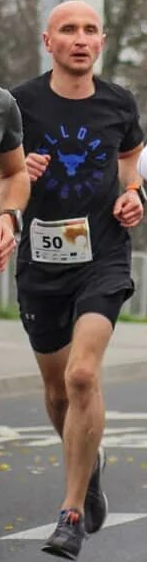


BIB DETECTED:


PERSON DETECTED: 


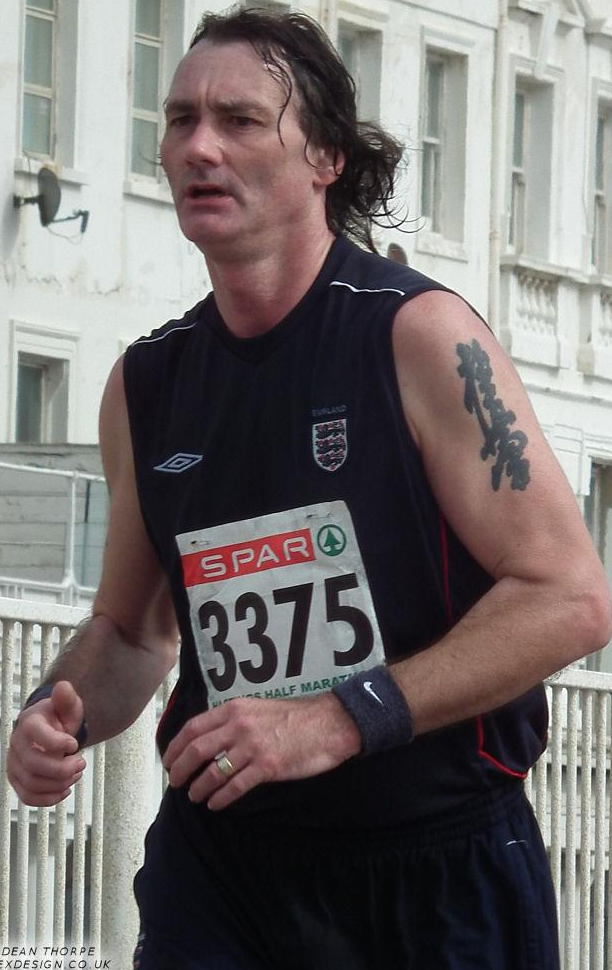


BIB DETECTED:


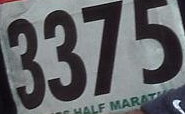

In [68]:
display_predictions(people_list, bibs_list)

The detection works on both models! 




Before I continue, I want to test this on a video. The video I am using is footage of my dad finishing the Boston Marathon in 2022:

# * The following is modified from an example: *

# Open the video file
video_path = "dad_boston_finish.MOV"
cap = cv2.VideoCapture(video_path)

total_people_list = []
total_bibs_list = []

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        people_list, bibs_list = prediction_pipeline_frames([frame])
        total_people_list += people_list
        total_bibs_list += bibs_list
        
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()

# Displaying the cropped images of the people and their bibs

for index in range(len(people_list)): # the length of people_list and bibs_list should be the same

    print(f'PERSON DETECTED:')
    display(people_list[index])
    print(f'\nBIB DETECTED:')
    display(bibs_list[index])

The next step is to take the people cropped images and detect their gender, and then take the bib cropped images and detect the numbers on them.

I will be using the pretrained ResNet50 CNN model and extracting features for the gender classification model. I referenced HW2 to do this.

In [69]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader

In [70]:
# Setup pretrained ResNet50 model

weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

model = resnet50(weights=weights)

In [71]:
# Get automatic transforms from pretrained weights
pretrained_transforms = weights.transforms()
print(pretrained_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [72]:
# *The following is modified from the examples.*

# I am NOT to fine-tune, so I will freeze all of the model's base layers.
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [73]:
train_dataset = ImageFolder(root='datasets/gender/train', transform=pretrained_transforms)
validation_dataset = ImageFolder(root='datasets/gender/test', transform=pretrained_transforms)

class_names = train_dataset.classes
print(f"Class Names: \n{class_names}")

Class Names: 
['man', 'woman']


In [74]:
# *The following is modified from the examples.*

num_workers = os.cpu_count() 

# Turn images into data loaders

train_dataloader = DataLoader(
      train_dataset,
      batch_size=32,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

validation_dataloader = DataLoader(
      validation_dataset,
      batch_size= 32, 
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )


In [75]:
# *The following is modified from the examples.*

from going_modular.going_modular import engine 
from helper_functions import set_seeds 

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()

'''

NOTE: this is commented out becuase I don't want to re-train the model everytime I run my notebook.
      You can add uncomment this if you wish to train the model.

training_results = engine.train(model=model,
                                train_dataloader=train_dataloader,
                                test_dataloader=validation_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=1,
                                device=device)
'''

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3456 | train_acc: 0.8588 | test_loss: 0.2696 | test_acc: 0.8903


Accuracy of 89% isn't too bad, so let's save the model how it is so it can be re-used in the future.

In [76]:
import joblib

# Save the entire model (including weights)
joblib.dump(model, 'gender_classifier_resnet50.pkl')

['gender_classifier_resnet50.pkl']

Now we have to make predicitions on the people images from the prediction_pipeline() function so that the gender of each person can be logged.

In [ ]:
# Make a list of all of the file paths in the test folder of the bib dataset